In [1]:
import intake
import xarray as xr 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from calendar import monthrange
import numpy as np
import cartopy
from tqdm import tqdm
from scipy import interpolate
import pandas as pd
import seaborn as sns
import os
from scipy import stats

#%config InlineBackend.figure_format='retina'

from matplotlib import gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

dataframe (Dataframe) - contains CMIP6 intake json 

In [2]:
historical_year_start = 2000
historical_year_end = 2014

future_year_start = 2086
future_year_end = 2100

In [3]:
parent_dir = '/home/jovyan/PlanetaryComputerExamples/Paper3/Paper3/Manuscript_final'

In [4]:
# necessary url
url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
# open the catalog
dataframe = intake.open_esm_datastore(url)

### Empirical data

In [5]:
#os.chdir('/home/jovyan/PlanetaryComputerExamples/Paper3')
Sr = xr.open_dataset(parent_dir+'/Empirical_data/Data_Rootzone-storage-capacity.nc').mle_gumbel[0]

# Interpolated data
new_lon = Sr.lon.values
new_lat = Sr.lat.values

In [6]:
Landuse_all = xr.open_dataset(parent_dir+'/Empirical_data/Landuse_resampled_0.25_lonlatbox.nc').sel(lat = slice(-50,50)).Band1

#Landuse with both forest and savanna
Landuse_with_savanna = Landuse_all.where((Landuse_all == 30) | (Landuse_all == 40) | (Landuse_all == 50) | (Landuse_all == 60) | (Landuse_all == 70) | (Landuse_all == 90) | (Landuse_all == 100) | (Landuse_all == 110) | (Landuse_all == 120) | (Landuse_all == 130) | (Landuse_all == 140) | (Landuse_all == 150))
## Landuse with only forest
Landuse = Landuse_all.where((Landuse_all == 40) | (Landuse_all == 50) | (Landuse_all == 60) | (Landuse_all == 70) | (Landuse_all == 90) | (Landuse_all == 100))
## landuse with only savanna
Landuse_only_savanna = Landuse_all.where((Landuse_all == 30) | (Landuse_all == 110) | (Landuse_all == 120) | (Landuse_all == 130) | (Landuse_all == 140) | (Landuse_all == 150))

In [7]:
P_CHIRPS = xr.open_dataset('/home/jovyan/PlanetaryComputerExamples/Paper3/Paper3/Manuscript_final/Empirical_data/chirps-v2.0.2000-2012.meanmonthly_p25.nc').precip

#### Defining functions

In [8]:
#Funtion to calulate days per month as a constant funtion (needs to be multiplied to CMIP6-precipitation estimates)
def sum_of_day(year_start, year_end, lat_1, lon_2):
    sum_of_day = []
    year = 0
    for year in range(year_start,year_end+1):
        for month in range(1,13):
            sum_of_day.append(monthrange(year, month)[1]*(np.ones((lat_1, lon_2)))*86400)
    sum_of_day = (np.array(sum_of_day))
    return sum_of_day

In [9]:
def calc_Seasonality(data):
    # Input is monthly data of precipitation
    Seasonality = []
    for lat in range(data.shape[1]):
        for lon in range(data.shape[2]):
            Seasonality.append(((1/data[:,lat,lon].sum())*(np.array([abs((data[i,lat,lon]-(data[:,lat,lon].sum()/12))) for i in range(12)]).sum())))
    Seasonality = (np.array(Seasonality).reshape(data.shape[1],data.shape[2]))
    return Seasonality

In [10]:
def calc_Seasonality_ind(data):
    # Input is monthly data of precipitation
    Seasonality = (((1/data[:].sum())*(np.array([abs((data[i]-(data[:].sum()/12))) for i in range(12)]).sum())))
    #Seasonality = (np.array(Seasonality).reshape(data.shape[1],data.shape[2]))
    return Seasonality

In [11]:
def interp_selfilter(file, Landuse,lat_min,lat_max,lon_min,lon_max):
    if isinstance(file,(np.ndarray)):
        file = xr.DataArray(file, coords=[lat, lon], dims=['lat', 'lon'], name = 'Variable', 
                            attrs=dict(description="Check the variable", units="Unit"))
        file = file.interp(lat=new_lat, lon=new_lon)
        file = file.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).where(Landuse.sel(lat = slice(lat_min,lat_max), 
                                                                                                      lon = slice(lon_min,lon_max)).values > 0)
    else:
        file = file.interp(lat=new_lat, lon=new_lon)
        file = file.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).where(Landuse.sel(lat = slice(lat_min,lat_max), 
                                                                                                      lon = slice(lon_min,lon_max)).values > 0)
    return file

In [12]:
def interp_selfilter_temporal(file, Landuse,lat_min,lat_max,lon_min,lon_max):
    file_out = np.zeros((12,interp_selfilter(file[0], Landuse,lat_min, lat_max, lon_min, lon_max).shape[0], interp_selfilter(file[0], Landuse,lat_min, lat_max, lon_min, lon_max).shape[1]))
    lat = interp_selfilter(CMIP6_prec_historical[11], Landuse,lat_min, lat_max, lon_min, lon_max).lat.values
    lon = interp_selfilter(CMIP6_prec_historical[11], Landuse,lat_min, lat_max, lon_min, lon_max).lon.values
    time = np.arange(1,13,1)
    for month in (range(12)):
        file_out[month,:,:] = interp_selfilter(file[month], Landuse,lat_min, lat_max, lon_min, lon_max).values
    file_out = xr.DataArray(file_out, coords=[time, lat, lon], dims=['month','lat', 'lon'], name = 'Variable',  
                                attrs=dict(description="Check the variable", units="Unit"))
    return file_out

#### Running analysis

In [13]:
# For South America
lat_min, lat_max, lon_min, lon_max = [-35,15,270,330]
if (lon_min == 270) & (lon_max == 330):
    Country = 'South America'
else:
    Country = 'Check country'

South America (Total Area) = 8216635.38904723 km^2

In [14]:
df_final = pd.read_csv(parent_dir+'/CMIP6-Future_models_all_(with Sr-eq)_South America.csv')

In [15]:
df_final

,institution_id,source_id,table_id,grid_label,historical,ssp126,ssp245,ssp370,ssp585,Sr-100eq,Sr-400eq
0,CSIRO-ARCCSS,ACCESS-CM2,Amon,gn,1,1,1,1,1,116.575532,409.900705
1,CSIRO,ACCESS-ESM1-5,Amon,gn,1,1,0,0,1,95.728133,314.000824
2,AWI,AWI-CM-1-1-MR,Amon,gn,1,1,1,1,1,127.053403,446.708181
3,BCC,BCC-CSM2-MR,Amon,gn,1,1,1,1,1,93.549910,348.750239
4,CAS,CAS-ESM2-0,Amon,gn,1,1,1,1,1,120.418121,336.189765
5,NCAR,CESM2-WACCM,Amon,gn,1,1,1,1,1,164.953056,445.445854
6,CMCC,CMCC-CM2-SR5,Amon,gn,1,1,1,1,1,155.168020,288.220768
7,CMCC,CMCC-ESM2,Amon,gn,1,1,1,1,1,147.600075,282.739693
8,CCCma,CanESM5,Amon,gn,1,1,1,1,1,194.054560,337.462342
9,E3SM-Project,E3SM-1-1,Amon,gr,1,0,0,0,1,165.402306,338.410103


In [16]:
def Seasonal_precipitation(SSP, Country, transition, baseline, ax=None, **kwargs):
    global describe
    # Country = 'SA' or 'AF'
    # Transition = 'tipping', 'willstress', 'willrecover'
    if Country == 'SA':
        lat_min, lat_max, lon_min, lon_max = [-35,15,270,330]
        Country_name = 'South America' 
    if Country == 'AF':
        lat_min, lat_max, lon_min, lon_max = [-35,15,0,55]
        Country_name = 'Africa'
    historical_year_start = 2000
    historical_year_end = 2014

    future_year_start = 2086
    future_year_end = 2100
    dataframe_temp = pd.DataFrame(columns=['J','F','M','A','M','J','J','A','S','O','N','D',r'$\overline{P}$', 'Seas.'])
    df_final_1 = df_final.where(df_final[SSP] == 1).dropna()
    for i in tqdm(range(df_final_1.shape[0])):
        temp_name = 'CMIP.'+df_final_1.iloc[i,0]+'.'+df_final_1.iloc[i,1]+'.'+'historical'+'.'+df_final_1.iloc[i,2]+'.'+df_final_1.iloc[i,3]
        CMIP6_prec_historical = 0
        CMIP6_prec_historical = (CMIP6_datasets['pr'][temp_name]).sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max), time = slice(str(historical_year_start),str(historical_year_end))).pr[0]
        CMIP6_prec_historical = CMIP6_prec_historical*sum_of_day(historical_year_start,historical_year_end,CMIP6_prec_historical.shape[1],CMIP6_prec_historical.shape[2])
        CMIP6_prec_historical = CMIP6_prec_historical.groupby('time.month').mean('time')

        data = xr.open_dataset(parent_dir+'/Dataexport_validation/'+Country+'_'+SSP+'_'+transition+'.nc').mle_gumbel
        if baseline == 'empirical':
            CMIP6_prec_empirical = P_CHIRPS.where(data > 0).mean(axis = (1,2)).values
            annual_P_emp = P_CHIRPS.where(data > 0).mean(axis = (1,2)).sum().values
            hist = CMIP6_prec_empirical
            Seas = calc_Seasonality_ind(hist)
            hist = np.concatenate((np.array(hist), np.array([annual_P_emp]), np.array([Seas])))
        data = data.interp(method='nearest', lat=CMIP6_prec_historical.lat.values, lon=CMIP6_prec_historical.lon.values)    
        if baseline == 'historical':
            hist = 0
            hist = CMIP6_prec_historical.where(data > 0).mean(axis = (1,2)).values
            annual_P = CMIP6_prec_historical.where(data > 0).mean(axis = (1,2)).sum().values
            Seas = calc_Seasonality_ind(hist)
            hist = np.concatenate((np.array(hist), np.array([annual_P]), np.array([Seas])))
        #print(hist)
        temp_name = 'ScenarioMIP.'+df_final_1.iloc[i,0]+'.'+df_final_1.iloc[i,1]+'.'+SSP+'.'+df_final_1.iloc[i,2]+'.'+df_final_1.iloc[i,3]
        if (df_final_1.iloc[i,1] == 'MPI-ESM1-2-HR'):
            temp_name = 'ScenarioMIP.'+'DKRZ'+'.'+df_final_1.iloc[i,1]+'.'+str(SSP)+'.'+df_final_1.iloc[i,2]+'.'+df_final_1.iloc[i,3]
        if (df_final_1.iloc[i,1] == 'IITM-ESM'):
            if (SSP == 'ssp370'):
                future_year_end = 2098
            else:
                future_year_end = 2099
        CMIP6_prec_future = 0
        CMIP6_prec_future = (CMIP6_datasets['pr'][temp_name]).sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max), time = slice(str(future_year_start),str(future_year_end))).pr[0]
        CMIP6_prec_future = CMIP6_prec_future*sum_of_day(future_year_start,future_year_end,CMIP6_prec_future.shape[1],CMIP6_prec_future.shape[2])
        CMIP6_prec_future = CMIP6_prec_future.groupby('time.month').mean('time')
        future = 0
        future = CMIP6_prec_future.where(data > 0).mean(axis = (1,2)).values
        annual_P_1 = CMIP6_prec_future.where(data > 0).mean(axis = (1,2)).sum().values
        Seas_1 = calc_Seasonality_ind(hist)
        future = np.concatenate((np.array(future), np.array([annual_P_1]), np.array([Seas_1]))) 
        #print(future)
        if future.mean() == 0:
            future[:] = np.nan
        dataframe_temp.loc[i] = ((future-hist)/hist*100)
    import seaborn as sns
    describe = dataframe_temp.describe()
    for percentile in np.round(np.arange(0.1,1,0.1), 1):
        describe.loc[str(percentile)] = dataframe_temp.quantile(percentile).values 
        #describe.loc['5th'] = dataframe_temp.quantile(0.05).values
        #describe.loc['50th'] = dataframe_temp.quantile(0.5).values
        #describe.loc['95th'] = dataframe_temp.quantile(0.95).values
    """ #When running on loop and saving figures
    fig = plt.figure(figsize=(10,2))
    if baseline == 'historical':
        sns.heatmap(describe.loc[['5th','50th','95th']], vmin = -50, vmax = 50, cmap = 'RdGy',
               square=True, linewidth=0.3, cbar_kws={"shrink": .8}) 
    if baseline == 'empirical':
        sns.heatmap(describe.loc[['5th','50th','95th']], vmin = -100, vmax = 100, cmap = 'RdGy',
               square=True, linewidth=0.3, cbar_kws={"shrink": .8}) 
    plt.ylabel('Percentile', fontsize = '15')
    plt.tick_params(axis='both', which='major', labelsize=12)
    if baseline == 'historical':
        dpi=100
        fig.savefig(parent_dir+'/Figures/'+Country_name+' '+SSP+' '+transition+' (CMIP6-historical vs SSPs).tif', dpi=100, bbox_inches="tight")
    if baseline == 'empirical':
        plt.title(Country_name+' '+SSP+' '+transition+' (Empirical vs SSPs)')
        fig.savefig(parent_dir+'/Figures/'+Country_name+' '+SSP+' '+transition+' (Empirical vs SSPs).tif', dpi=100, bbox_inches="tight")
    plt.show()
    #data.plot()
    #plt.show()
    """
    y_axis_labels = ['10th', '20th', '30th', '40th', '50th', '60th', '70th', '80th', '90th']
    if baseline == 'historical':
        sns.heatmap(describe.loc[['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']], vmin = -50, vmax = 50, cmap = 'seismic_r',
               square=True, linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax, yticklabels=y_axis_labels) 
        ax.set_title(Country_name+' '+SSP, fontsize = 10)
    if baseline == 'empirical':
        sns.heatmap(describe.loc[['0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8', '0.9']], vmin = -100, vmax = 100, cmap = 'seismic_r',
               square=True, linewidth=0.3, cbar_kws={"shrink": .8}, ax = ax, yticklabels=y_axis_labels)
        ax.set_title(Country_name+' '+SSP, fontsize = 10)
    ax.set_ylabel('Percentile', fontsize = '10')
    ax.tick_params(axis='both', which='major', labelsize=8)

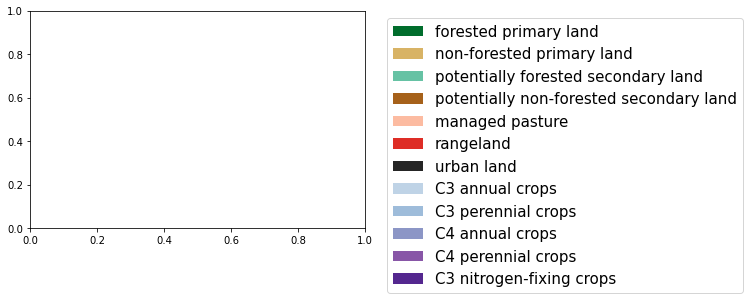

In [17]:
## Plotting ecoregion legend
color = ['#006d2c', '#d8b365', '#66c2a4',
         '#a6611a', '#fcbba1', '#de2d26',
         '#252525', '#bfd3e6','#9ebcda',
         '#8c96c6','#8856a7','#54278f']
Ecozone_unique_name = ['forested primary land', 'non-forested primary land', 'potentially forested secondary land',
                       'potentially non-forested secondary land', 'managed pasture', 'rangeland',
                       'urban land', 'C3 annual crops', 'C3 perennial crops', 'C4 annual crops', 
                       'C4 perennial crops', 'C3 nitrogen-fixing crops']

import matplotlib.patches as mpatches
from matplotlib.font_manager import FontProperties

recs = []
for i in range(0,len(color)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=color[i]))
fontP = FontProperties()
fontP.set_size('15')
plt.legend(recs,Ecozone_unique_name, ncol = 1,prop=fontP, bbox_to_anchor=(2.15, 1))

In [24]:
SSP = 'ssp585'
LUH2 = xr.open_dataset(parent_dir+'/LUMIP_data/multiple-states_input4MIPs_landState_ScenarioMIP_'+SSP+'_2015-2100.nc', decode_times=False)

In [25]:
LUH2

<xarray.Dataset>
Dimensions:     (time: 86, lat: 720, lon: 1440, bounds: 2)
Coordinates:
  * time        (time) float64 0.0 1.0 2.0 3.0 4.0 ... 81.0 82.0 83.0 84.0 85.0
  * lat         (lat) float64 89.88 89.62 89.38 89.12 ... -89.38 -89.62 -89.88
  * lon         (lon) float64 -179.9 -179.6 -179.4 -179.1 ... 179.4 179.6 179.9
Dimensions without coordinates: bounds
Data variables: (12/17)
    primf       (time, lat, lon) float32 ...
    primn       (time, lat, lon) float32 ...
    secdf       (time, lat, lon) float32 ...
    secdn       (time, lat, lon) float32 ...
    urban       (time, lat, lon) float32 ...
    c3ann       (time, lat, lon) float32 ...
    ...          ...
    range       (time, lat, lon) float32 ...
    secmb       (time, lat, lon) float32 ...
    secma       (time, lat, lon) float32 ...
    lat_bounds  (lat, bounds) float64 ...
    lon_bounds  (lon, bounds) float64 ...
    time_bnds   (time, bounds) int32 ...
Attributes: (12/24)
    host:                    UMD College Park
    comment:                 LUH2
    contact:                 gchurtt@umd.edu, lchini@umd.edu, steve.frolking@...
    creation_date:           2017-09-16T23:15:45Z
    title:                   UofMD LUH2f dataset prepared for input4MIPs
    activity_id:             input4MIPs
    ...                      ...
    references:              Hurtt, Chini et al. 2011
    license:                 Land-Use Harmonization data produced by the Univ...
    target_mip:              [‘ScenarioMIP’, ‘AerChemMIP’, ‘C4MIP’, ‘DCPP’, ‘...
    source_id:               UofMD-landState-MAGPIE-ssp585-2-1-f
    variable_id:             multiple-states
    tracking_id:             hdl:21.14100/e23c2e86-fe74-4627-9dd4-823926ff29f7

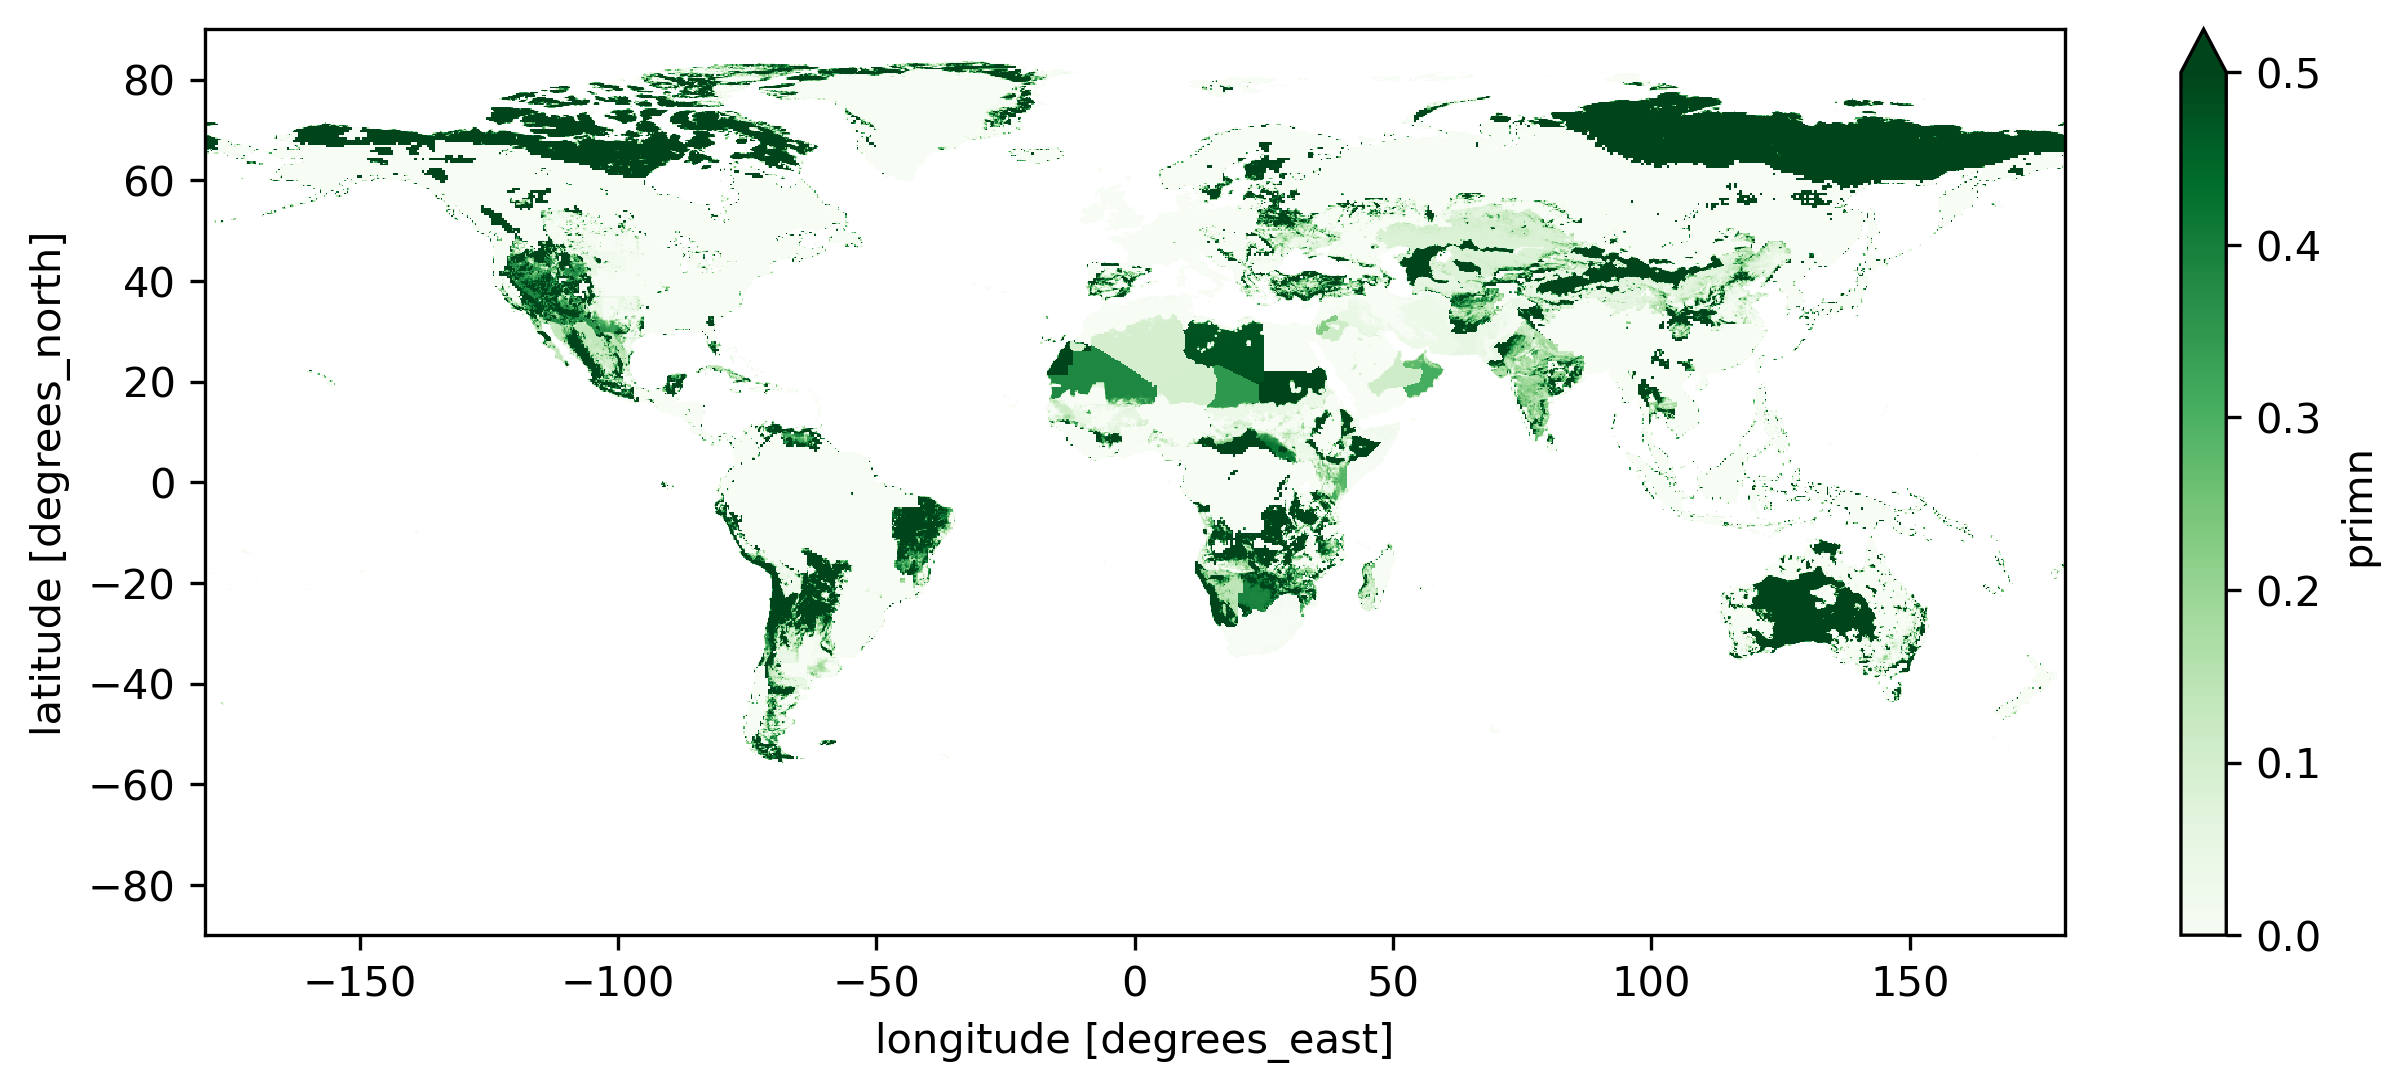

In [31]:
fig = plt.subplots(figsize=(10,4), sharex='col', dpi = 300)
LUH2.primn[0:1].median(axis = 0).plot(vmax = 0.5, cmap = 'Greens')

In [14]:
def LUMIP_forest_transition_2300(SSP, Country, transition, ax=None, **kwargs):
    global dataframe_temp, Area
    columns=['primf','primn','secdf','secdn','pastr','range','urban','c3ann','c3per','c4ann','c4per','c3nfx']
    if Country == 'SA':
        lat_min, lat_max, lon_min, lon_max = [-35,15,270,330]
        Country_name = 'South America' 
    if Country == 'AF':
        lat_min, lat_max, lon_min, lon_max = [-35,15,0,55]
        Country_name = 'Africa'

    Area = xr.open_dataset(parent_dir+'/Empirical_data/gridarea.nc').cell_area.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max))[:,:-1].where(Landuse.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).values > 0)
    Area = Area/(1000000) ## m2 to km2
    data = xr.open_dataset(parent_dir+'/Dataexport_validation/'+Country+'_'+SSP+'_'+transition+'.nc').mle_gumbel
    Area = Area.where(data.values > 0)
    
    color = ['#006d2c', '#d8b365', '#66c2a4',
             '#a6611a', '#fcbba1', '#de2d26',
             '#252525', '#bfd3e6','#9ebcda',
             '#8c96c6','#8856a7','#54278f']
    
    if (SSP == 'ssp585') | (SSP == 'ssp126'):
        LUMIP_2200 = []
        LUMIP_2300 = []
        for column in tqdm(columns):
            test_2 = xr.open_dataset(parent_dir+'/LUMIP_data/multiple-states_input4MIPs_landState_ScenarioMIP_'+SSP+'_2100-2300.nc', decode_times=False)
            test_2.coords['lon'] = (np.where((test_2.lon.values>0), (test_2.lon.values), (test_2.lon.values)+360))
            test_2 = test_2.sortby(test_2.lon); test_2 = test_2.sortby(test_2.lat)
            test_2200 = test_2[column][86:100]
            test_2200 = test_2200.median(axis = 0)
            test_2200 = test_2200.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).where(Landuse.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).values > 0)
            test_2200 = test_2200.where(data.values > 0)
            test_2300 = test_2[column][186:200]
            test_2300 = test_2300.median(axis = 0)
            test_2300 = test_2300.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).where(Landuse.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).values > 0)
            test_2300 = test_2300.where(data.values > 0)
            LUMIP_2200.append((Area*test_2200.values/1000000).sum().values)
            LUMIP_2300.append((Area*test_2300.values/1000000).sum().values)
        dataframe_temp = pd.DataFrame([columns])
        dataframe_temp.loc[0] = np.array(LUMIP_2200)
        dataframe_temp.loc[1] = np.array(LUMIP_2300)
        
        ax.bar([2200,2300], dataframe_temp[0], width = 50, color = color[0]);
        bottom = dataframe_temp[0];
        for i in range(1,12):
            ax.bar([2200,2300], dataframe_temp[i], width = 50, bottom = bottom, color = color[i])
            bottom = bottom + dataframe_temp[i]
            
    ax.set_ylim(0,Area.sum()/1000000)
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(axis='both', which='major', labelsize=14)
    #ax.set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')
    ax.set_yticks([])
    #ax.set_title(Country+'_'+SSP+'_'+transition)

In [6]:
def LUMIP_forest_transition_2015_2100(SSP, Country, transition, ax=None, **kwargs):
    columns=['primf','primn','secdf','secdn','pastr','range','urban','c3ann','c3per','c4ann','c4per','c3nfx']
    if Country == 'SA':
        lat_min, lat_max, lon_min, lon_max = [-35,15,270,330]
        Country_name = 'South America' 
    if Country == 'AF':
        lat_min, lat_max, lon_min, lon_max = [-35,15,0,55]
        Country_name = 'Africa'

    Area = xr.open_dataset(parent_dir+'/Empirical_data/gridarea.nc').cell_area.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max))[:,:-1].where(Landuse.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).values > 0)
    Area = Area/(1000000) ## m2 to km2
    data = xr.open_dataset(parent_dir+'/Dataexport_validation/'+Country+'_'+SSP+'_'+transition+'.nc').mle_gumbel
    Area = Area.where(data.values > 0)

    color = ['#006d2c', '#d8b365', '#66c2a4',
                 '#a6611a', '#fcbba1', '#de2d26',
                 '#252525', '#bfd3e6','#9ebcda',
                 '#8c96c6','#8856a7','#54278f']
    i = 0
    for column in tqdm(columns):
        test = xr.open_dataset(parent_dir+'/LUMIP_data/multiple-states_input4MIPs_landState_ScenarioMIP_'+SSP+'_2015-2100.nc', decode_times=False)
        test.coords['lon'] = (np.where((test.lon.values>0), (test.lon.values), (test.lon.values)+360))
        test = test.sortby(test.lon); test = test.sortby(test.lat)
        test = test[column]
        test = test.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).where(Landuse.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min,lon_max)).values > 0)
        test = test.where(data.values > 0)
        for array in range(test.shape[0]):
            test[array,:] = ((test[array])*Area.values/1000000)
        test = test.sum(axis = (1,2))
        if i == 0:
            df = pd.DataFrame({
                str(column): test}, 
                index=np.arange(2015,2101,1))
        else:
            df[column] = test
        i = i+1
    df.plot.area(color = color, ax = ax, legend=False)
    ax.set_ylim(0,Area.sum()/1000000)
    ax.tick_params(axis='x', labelrotation=90)
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.set_xticks([2015,2050,2100])

    #ax.set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')

100%|██████████| 12/12 [00:07<00:00,  1.64it/s]


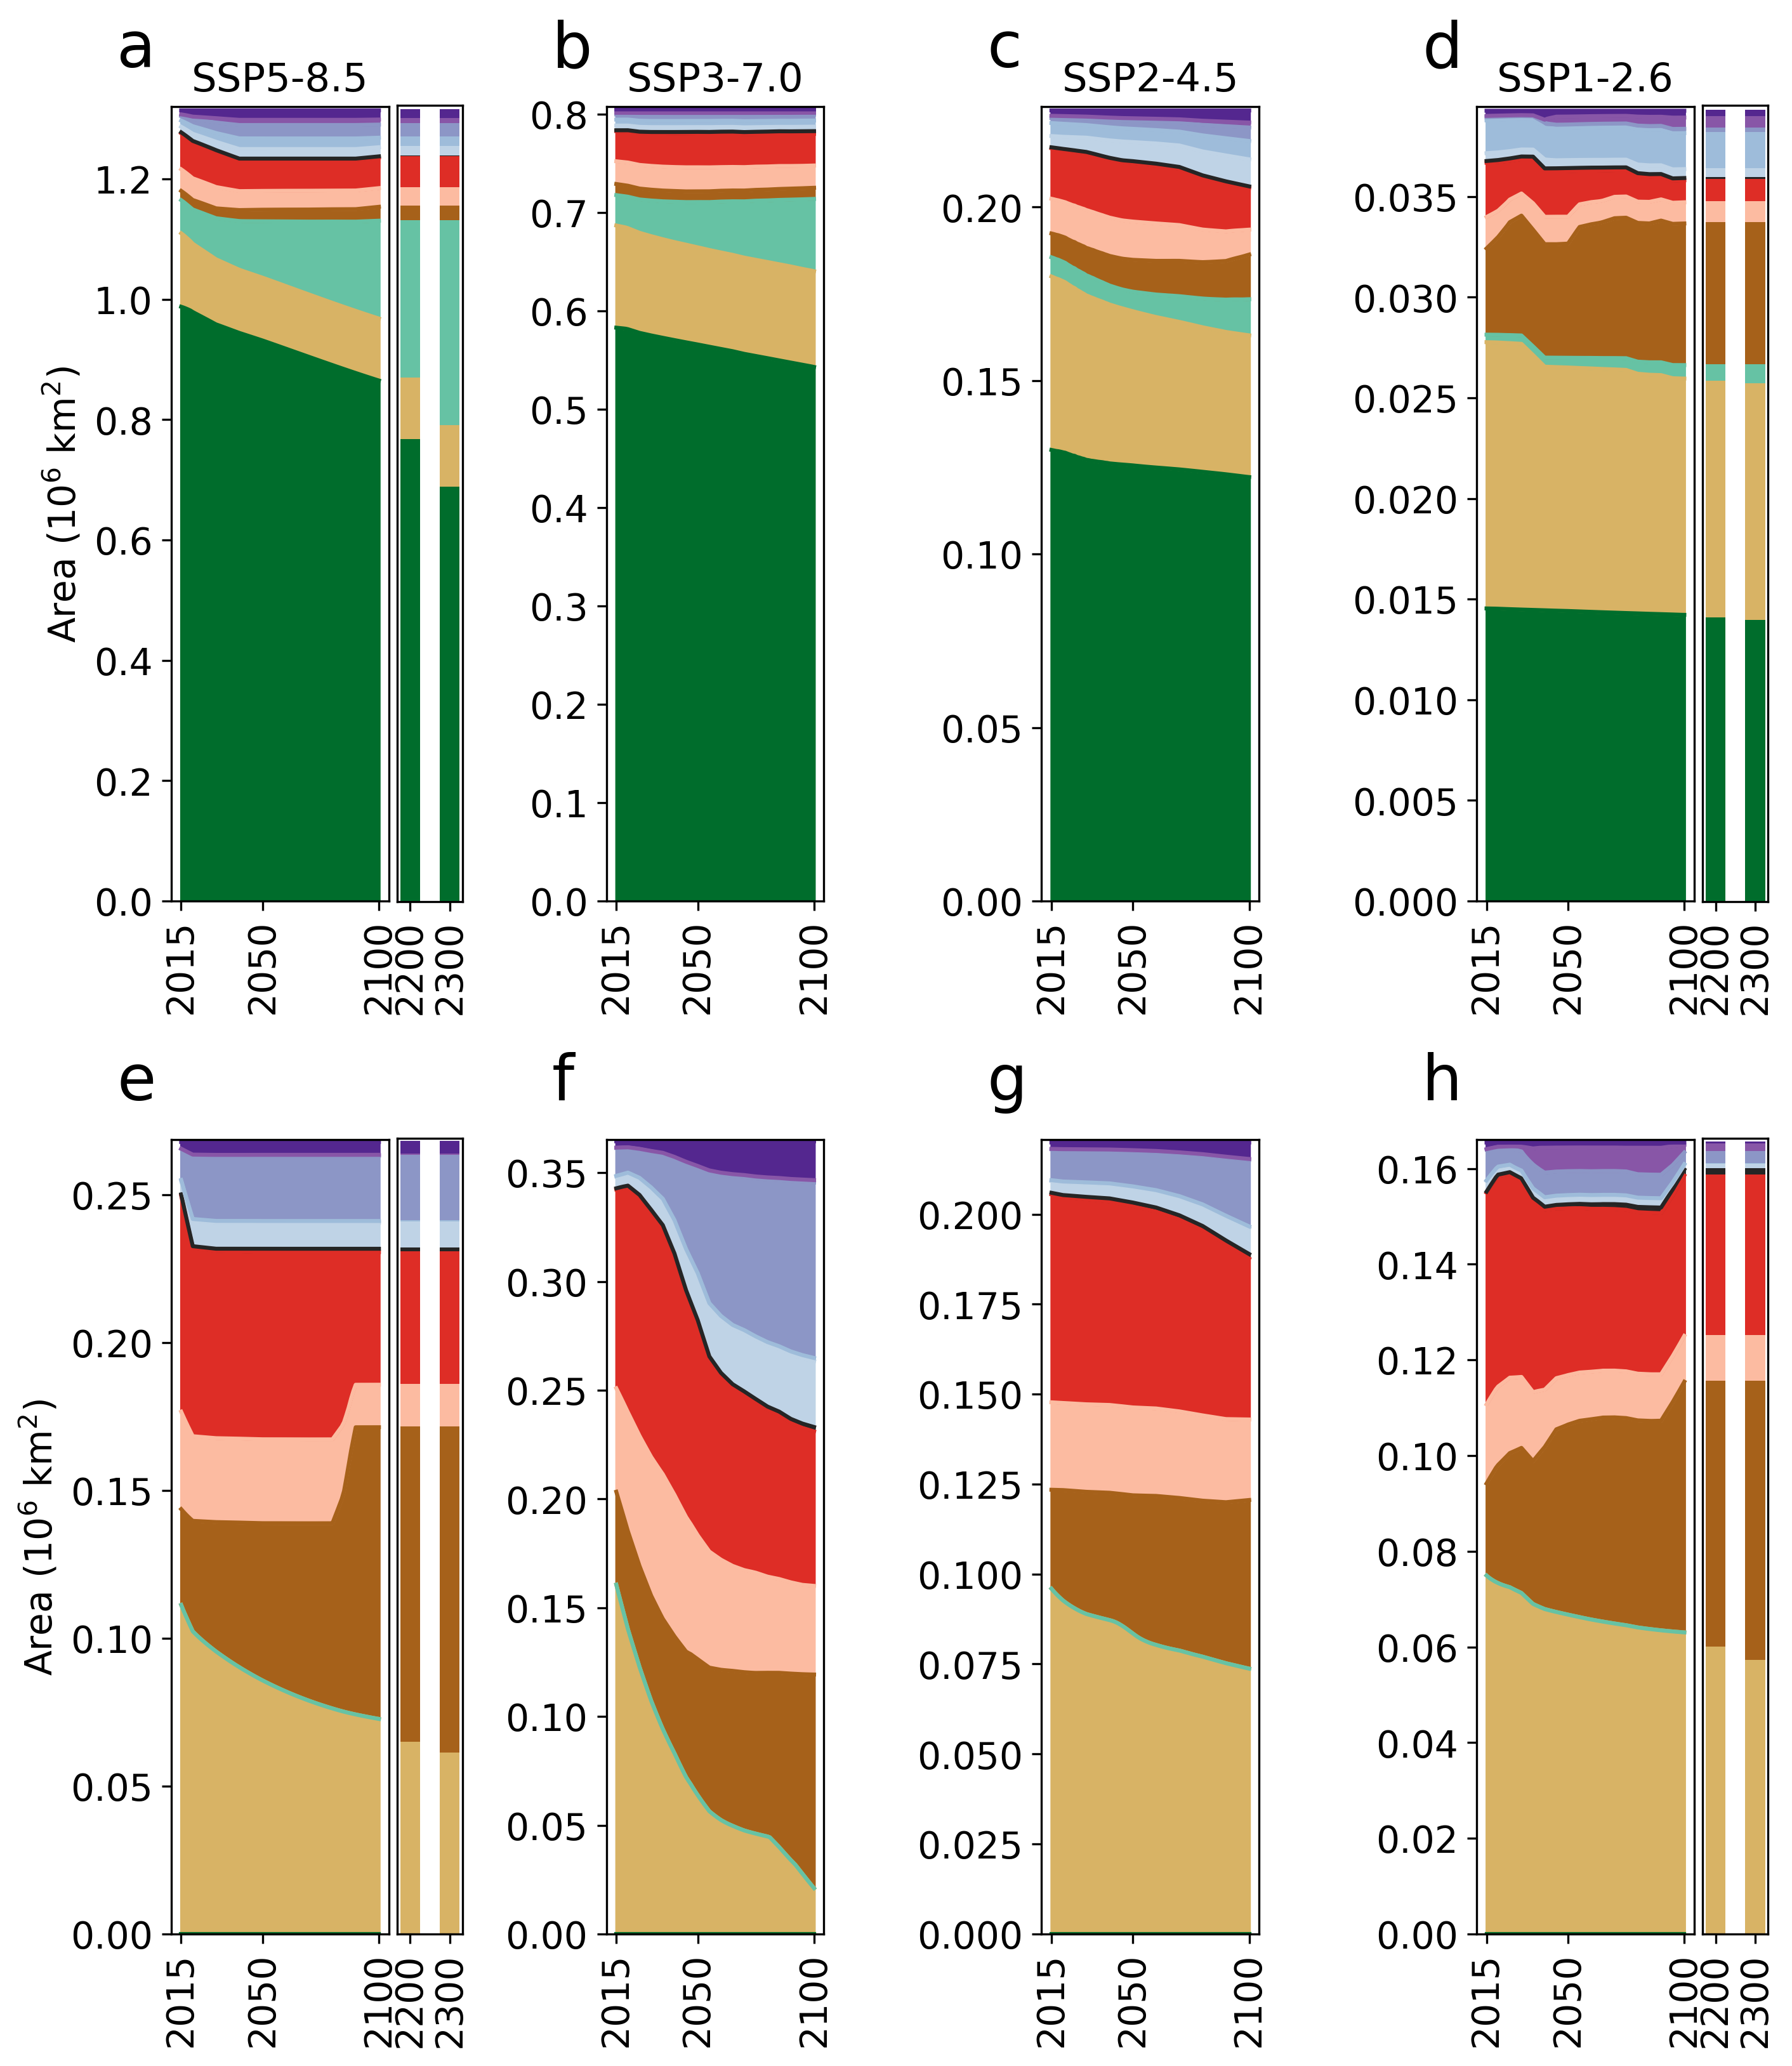

In [157]:
i = 0
transition = 'tipping'
fig, ax = plt.subplots(2,4, figsize=(10,12), dpi = 300)
for SSP in ['ssp585','ssp370','ssp245','ssp126']:
    LUMIP_forest_transition_2015_2100(SSP, 'SA', transition, ax  = ax[0,i])
    if (SSP == 'ssp585') | (SSP == 'ssp126'):
        axs = inset_axes(ax[0,i], width="30%", height="60%", loc='lower right', bbox_to_anchor=(0.4,-0.017,1,1.670), bbox_transform=ax[0,i].transAxes)
        LUMIP_forest_transition_2300(SSP, 'SA', transition, ax = axs)

    LUMIP_forest_transition_2015_2100(SSP, 'AF', transition, ax  = ax[1,i])
    if (SSP == 'ssp585') | (SSP == 'ssp126'):
        axs = inset_axes(ax[1,i], width="30%", height="60%", loc='lower right', bbox_to_anchor=(0.4,-0.017,1,1.670), bbox_transform=ax[1,i].transAxes)
        LUMIP_forest_transition_2300(SSP, 'AF', transition, ax = axs)
    i = i+1
ax[0,0].set_title('SSP5-8.5', fontsize = '15', color = 'black');
ax[0,1].set_title('SSP3-7.0', fontsize = '15', color = 'black');
ax[0,2].set_title('SSP2-4.5', fontsize = '15', color = 'black');
ax[0,3].set_title('SSP1-2.6', fontsize = '15', color = 'black');
ax[0,0].set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')
ax[1,0].set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')

import string
axs = ax.flat
for n, ax in enumerate(axs):
    ax.text(-0.25, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
                    size=24)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=1, hspace=0.3)

plt.savefig(parent_dir+'/Figures/Supplementary_Fig14_IAMs_tipping.tif', dpi=300)

100%|██████████| 12/12 [00:07<00:00,  1.66it/s]


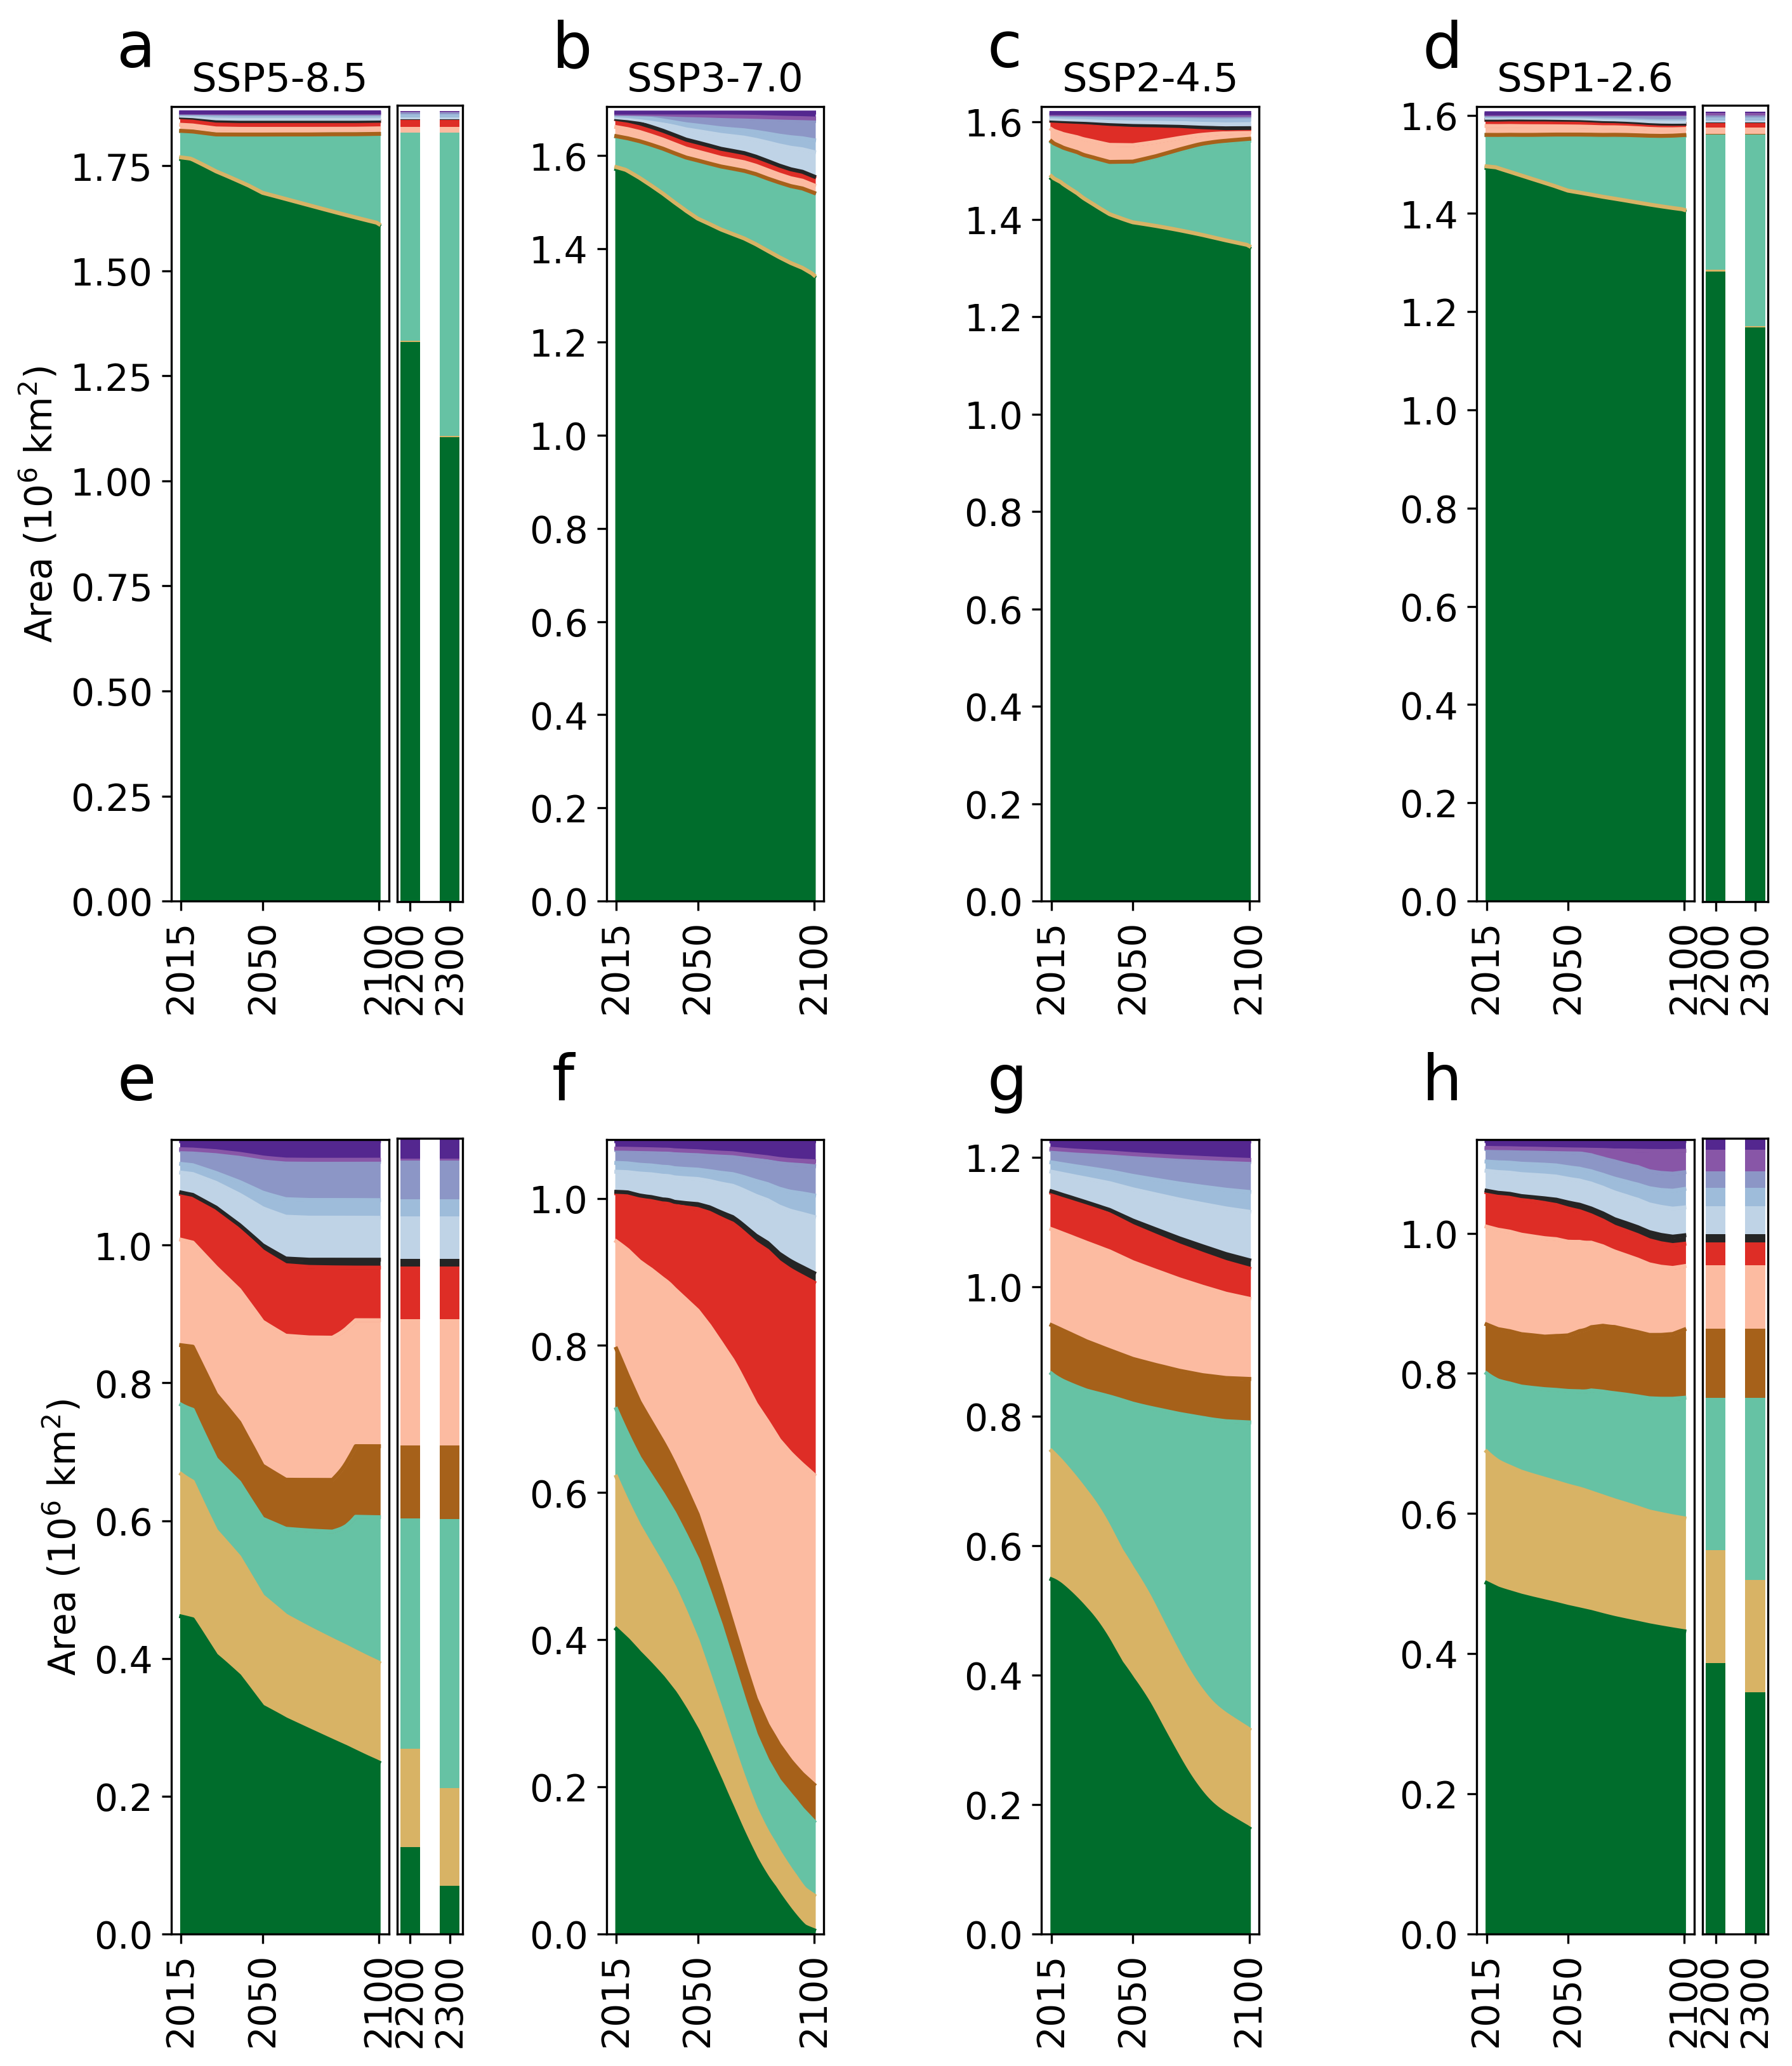

In [158]:
i = 0
transition = 'willstress'
fig, ax = plt.subplots(2,4, figsize=(10,12), dpi = 300)
for SSP in ['ssp585','ssp370','ssp245','ssp126']:
    LUMIP_forest_transition_2015_2100(SSP, 'SA', transition, ax  = ax[0,i])
    if (SSP == 'ssp585') | (SSP == 'ssp126'):
        axs = inset_axes(ax[0,i], width="30%", height="60%", loc='lower right', bbox_to_anchor=(0.4,-0.017,1,1.670), bbox_transform=ax[0,i].transAxes)
        LUMIP_forest_transition_2300(SSP, 'SA', transition, ax = axs)
    
    LUMIP_forest_transition_2015_2100(SSP, 'AF', transition, ax  = ax[1,i])
    if (SSP == 'ssp585') | (SSP == 'ssp126'):
        axs = inset_axes(ax[1,i], width="30%", height="60%", loc='lower right', bbox_to_anchor=(0.4,-0.017,1,1.670), bbox_transform=ax[1,i].transAxes)
        LUMIP_forest_transition_2300(SSP, 'AF', transition, ax = axs)
    i = i+1
ax[0,0].set_title('SSP5-8.5', fontsize = '15', color = 'black');
ax[0,1].set_title('SSP3-7.0', fontsize = '15', color = 'black');
ax[0,2].set_title('SSP2-4.5', fontsize = '15', color = 'black');
ax[0,3].set_title('SSP1-2.6', fontsize = '15', color = 'black');
ax[0,0].set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')
ax[1,0].set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')

import string
axs = ax.flat
for n, ax in enumerate(axs):
    ax.text(-0.25, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
                    size=24)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=1, hspace=0.3)
plt.savefig(parent_dir+'/Figures/Supplementary_Fig15_IAMs_willstress.tif', dpi=300)

100%|██████████| 12/12 [00:07<00:00,  1.68it/s]


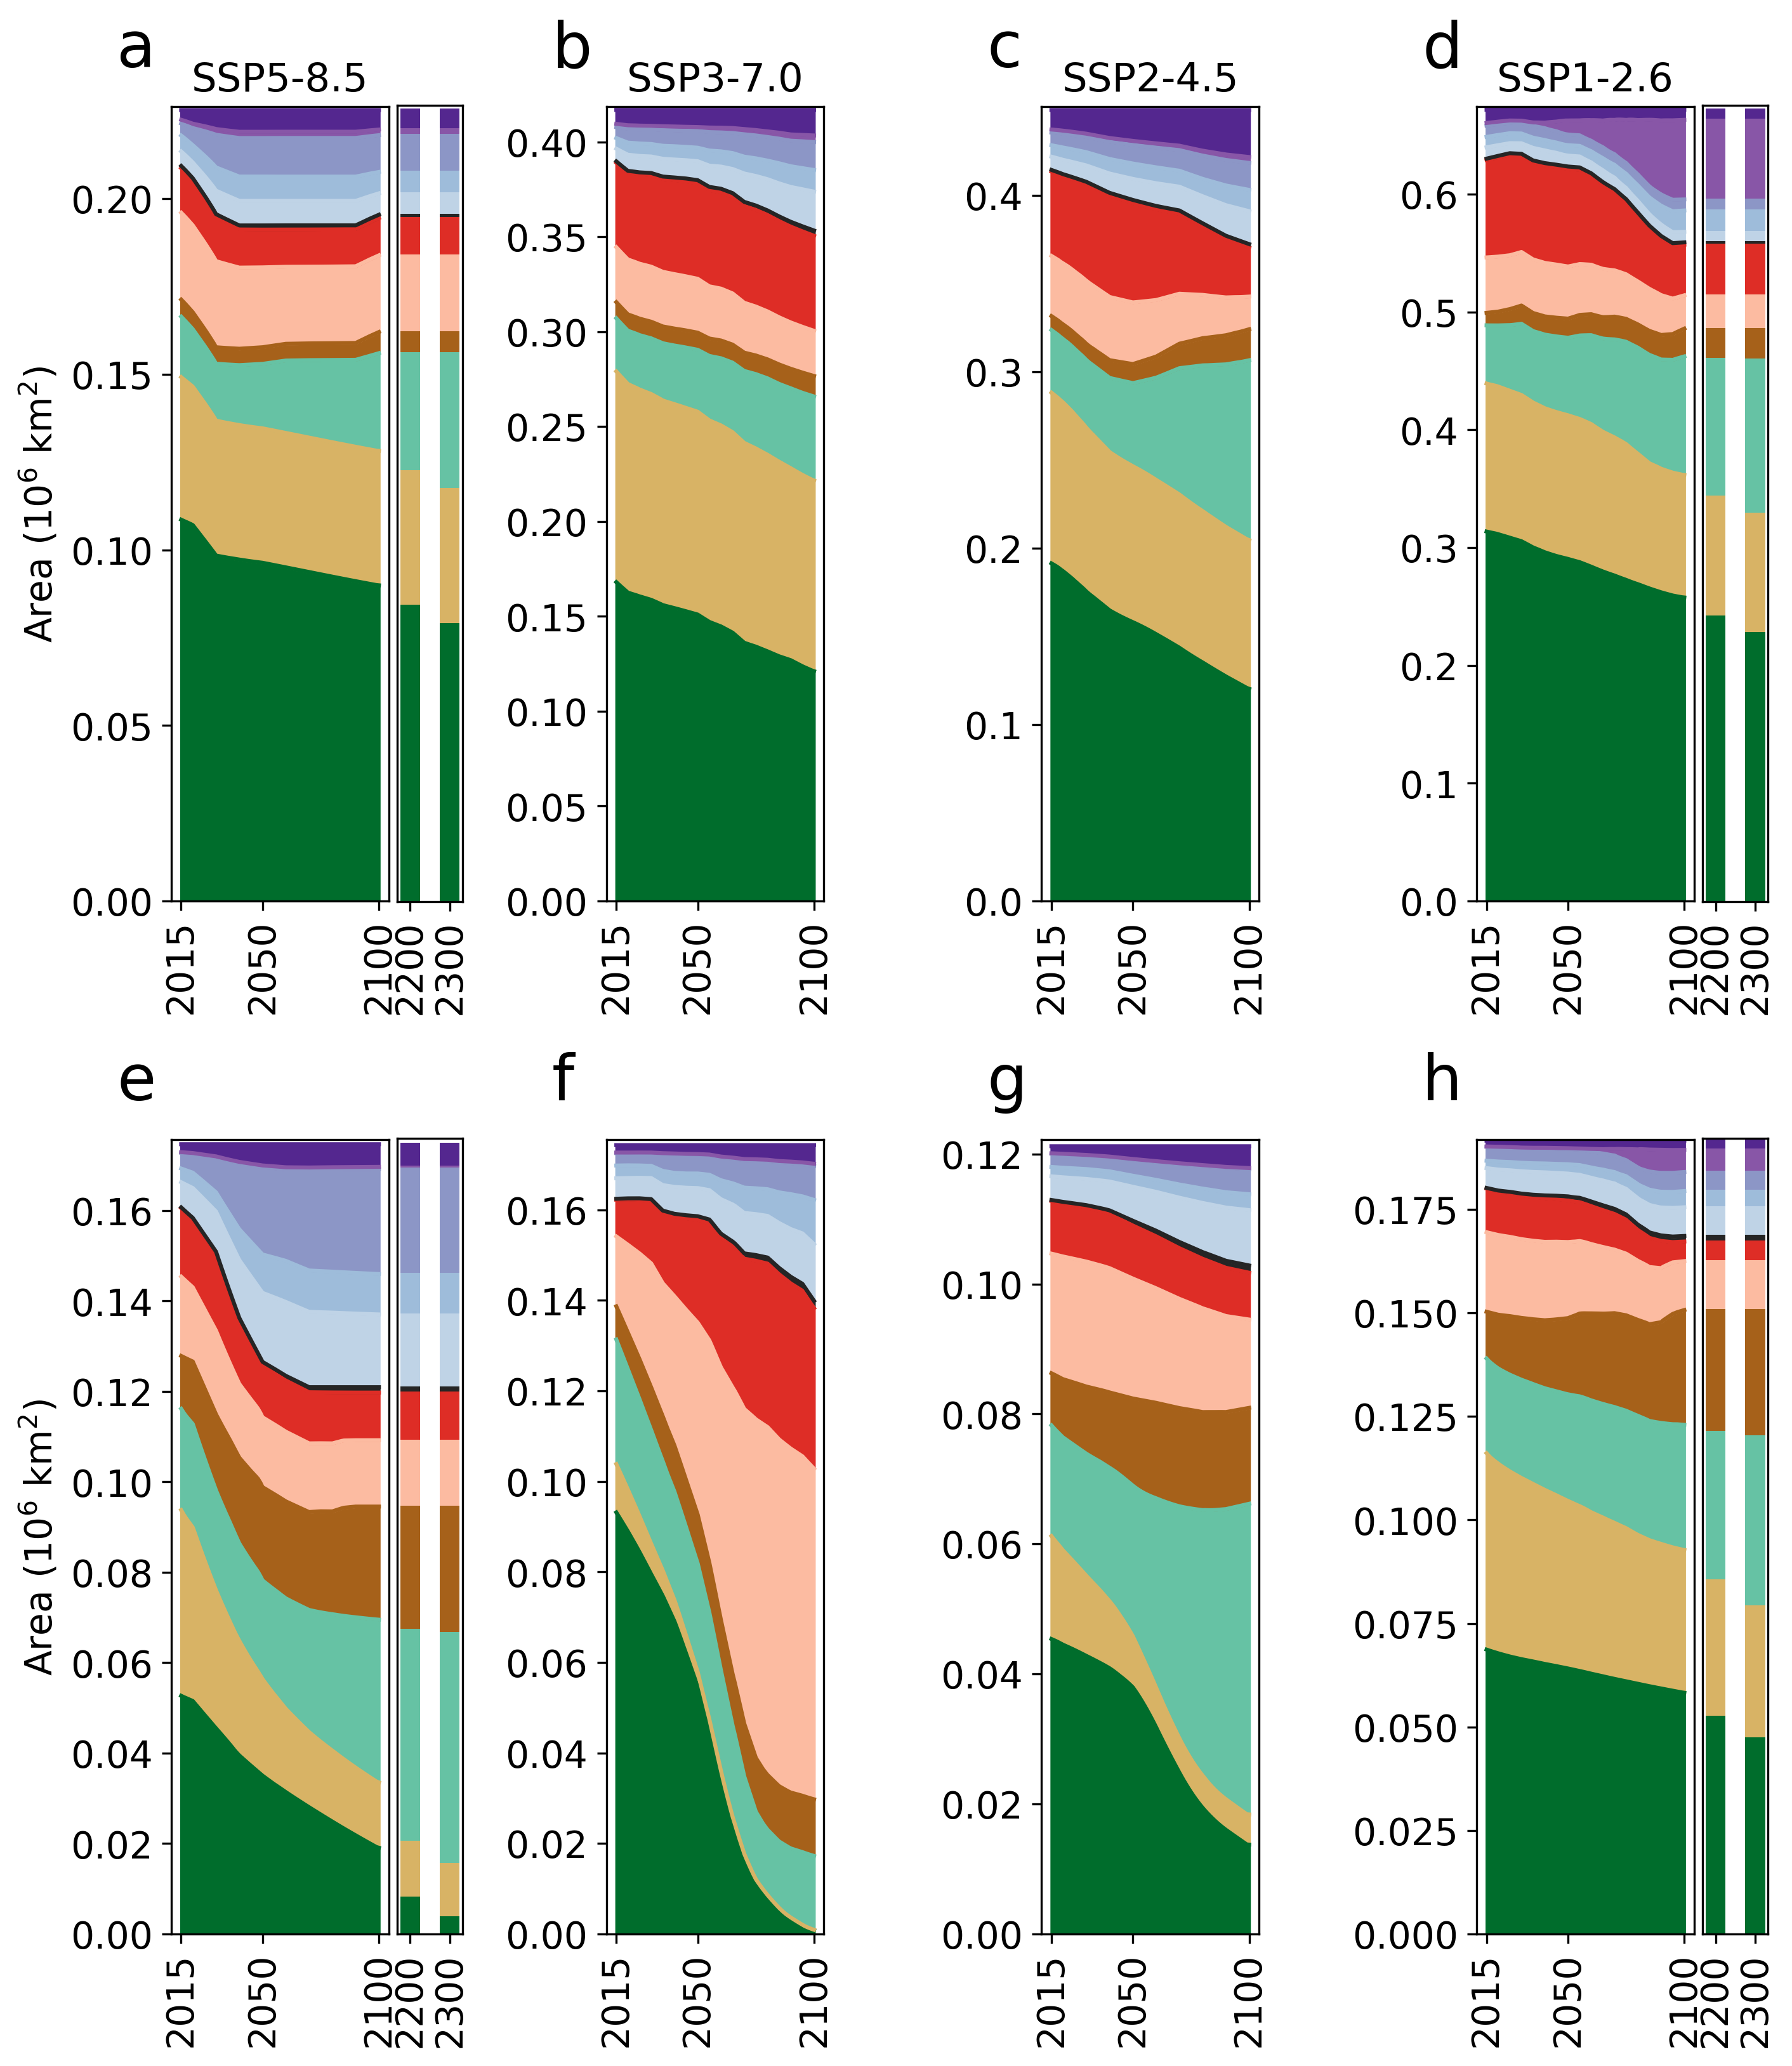

In [159]:
i = 0
transition = 'willrecover'
fig, ax = plt.subplots(2,4, figsize=(10,12), dpi = 300)
for SSP in ['ssp585','ssp370','ssp245','ssp126']:
    LUMIP_forest_transition_2015_2100(SSP, 'SA', transition, ax  = ax[0,i])
    if (SSP == 'ssp585') | (SSP == 'ssp126'):
        axs = inset_axes(ax[0,i], width="30%", height="60%", loc='lower right', bbox_to_anchor=(0.4,-0.017,1,1.670), bbox_transform=ax[0,i].transAxes)
        LUMIP_forest_transition_2300(SSP, 'SA', transition, ax = axs)
    
    LUMIP_forest_transition_2015_2100(SSP, 'AF', transition, ax  = ax[1,i])
    if (SSP == 'ssp585') | (SSP == 'ssp126'):
        axs = inset_axes(ax[1,i], width="30%", height="60%", loc='lower right', bbox_to_anchor=(0.4,-0.017,1,1.670), bbox_transform=ax[1,i].transAxes)
        LUMIP_forest_transition_2300(SSP, 'AF', transition, ax = axs)
    i = i+1
ax[0,0].set_title('SSP5-8.5', fontsize = '15', color = 'black');
ax[0,1].set_title('SSP3-7.0', fontsize = '15', color = 'black');
ax[0,2].set_title('SSP2-4.5', fontsize = '15', color = 'black');
ax[0,3].set_title('SSP1-2.6', fontsize = '15', color = 'black');
ax[0,0].set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')
ax[1,0].set_ylabel(r'Area (10$^{6}$ km$^{2}$)', fontsize = '14')

import string
axs = ax.flat
for n, ax in enumerate(axs):
    ax.text(-0.25, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
                    size=24)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=1, hspace=0.3)
plt.savefig(parent_dir+'/Figures/Supplementary_Fig16_IAMs_willrecover.tif', dpi=300)

In [12]:
# For South America
lat_min, lat_max, lon_min, lon_max = [-35,15,270,330]
# For Africa
AF_lat_min, AF_lat_max, AF_lon_min, AF_lon_max = [-35,15,0,55]

In [9]:
Sr_monthly = xr.open_dataset(parent_dir+'/Empirical_data/Sr-20year-return-period.2001-2012monthly.nc').Sr

In [190]:
def Sr_slice(Sr, Sr_monthly, lat_min, lat_max, lon_min, lon_max, ax=None, **kwargs):
    Sr = Sr.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min, lon_max))
    Sr = Sr.where(Landuse.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min, lon_max)).values > 0)
    if lon_min == 270:
        Sr_monthly = Sr_monthly.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min, lon_max))
    if lon_min == 0:
        Sr_monthly = Sr_monthly.sel(lat = slice(AF_lat_min,AF_lat_max), lon = slice(AF_lon_min, AF_lon_max))[:,:-1]
    Sr_monthly = Sr_monthly.where(Landuse.sel(lat = slice(lat_min,lat_max), lon = slice(lon_min, lon_max)).values > 0)
    #return Sr, Sr_monthly

    import pandas as pd
    import matplotlib.pyplot as plt
    from sklearn import linear_model

    ######################################## Data preparation #########################################
    temp = pd.DataFrame({'Sr': Sr.values.flatten(), 
                             'Sr_monthly': Sr_monthly.values.flatten()}, columns=['Sr', 'Sr_monthly']).dropna()
    X = temp['Sr'].values.reshape(-1,1)
    y = temp['Sr_monthly'].values
        ################################################ Train #############################################

    ols = linear_model.LinearRegression()
    model = ols.fit(X, y)
    response = model.predict(X)
        ############################################## Evaluate ############################################
    r2 = model.score(X, y)

    X2 = sm.add_constant(X)
    est = sm.OLS(y, X2)
    est2 = est.fit()
    p_value = est2.pvalues

        ############################################## Plot ################################################
    #fig, ax = plt.subplots(figsize=(5, 5))

    ax.plot(X, response, color='r', label='Regression model')
    ax.scatter(X, y, edgecolor='k', facecolor='grey', alpha=0.7, label='Sample data')
    ax.set_ylabel('$S_r$ (mm; derived from \nmonthly $P$ and $E$ estimates)', fontsize=14)
    ax.set_xlabel('$S_r$ (mm; derived from \ndaily $P$ and $E$ estimates)', fontsize=14)
    #ax.legend(facecolor='white', fontsize=11)
    ax.text(0.55, 0.15, '$y = %.2f x - %.2f $' % (model.coef_[0], abs(model.intercept_)), 
                fontsize=12, transform=ax.transAxes)
    ax.text(0.55, 0.10,'$R^2= %.2f$' % r2, fontsize=12, transform=ax.transAxes)
    if p_value[1] < 0.001:
        ax.text(0.55, 0.05,'$\mathit{p < 0.001}$', fontsize=12, transform=ax.transAxes)
    else:
        ax.text(0.55, 0.05,'$\mathit{p = %.2f}$' % p_value[1], fontsize=12, transform=ax.transAxes)
    ax.set_xlim(-100,1000)
    ax.set_ylim(-100,1000)
    ax.plot([-100,1000],[-100,1000], color='k', ls = '--')
    ax.tick_params(axis='both', which='major', labelsize=13)

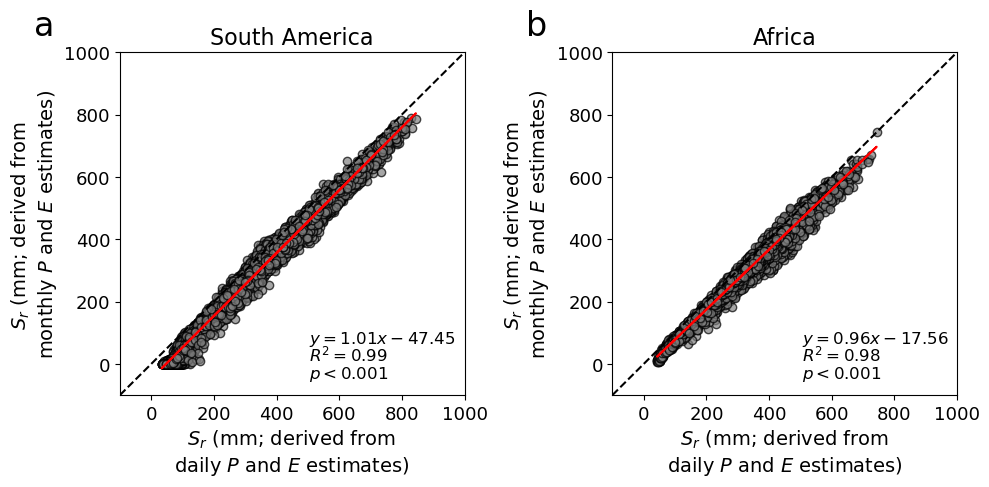

In [192]:
fig, ax = plt.subplots(1,2,figsize=(10, 5))
Sr_slice(Sr, Sr_monthly, lat_min, lat_max, lon_min, lon_max, ax = ax[0])
Sr_slice(Sr, Sr_monthly, AF_lat_min, AF_lat_max, AF_lon_min, AF_lon_max, ax = ax[1])
ax[0].set_title('South America', fontsize = 16)
ax[1].set_title('Africa', fontsize = 16)

import string
axs = ax.flat
for n, ax in enumerate(axs):
    ax.text(-0.25, 1.05, string.ascii_lowercase[n], transform=ax.transAxes, 
                    size=24)

plt.tight_layout()
fig.savefig(parent_dir+'/Figures/Supplementary_Fig21_Sr_comparison(daily-monthly).tif', dpi=300)